# Geospatial Earthquake Analysis and Machine Learning Project

### Connor McManigal

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns

In [2]:
# earthquake dataset (https://www.kaggle.com/datasets/shreyasur965/recent-earthquakes/data)
df = pd.read_csv("~/Desktop/GeoSpatial/data/earthquakes.csv")
usa = df[df['country'] == 'United States of America (the)']
print(df.shape)
print(usa.shape)
print(df.columns)

(1137, 43)
(423, 43)
Index(['id', 'magnitude', 'type', 'title', 'date', 'time', 'updated', 'url',
       'detailUrl', 'felt', 'cdi', 'mmi', 'alert', 'status', 'tsunami', 'sig',
       'net', 'code', 'ids', 'sources', 'types', 'nst', 'dmin', 'rms', 'gap',
       'magType', 'geometryType', 'depth', 'latitude', 'longitude', 'place',
       'distanceKM', 'placeOnly', 'location', 'continent', 'country',
       'subnational', 'city', 'locality', 'postcode', 'what3words', 'timezone',
       'locationDetails'],
      dtype='object')


In [4]:
# fill in missing state info
usa.loc[usa['subnational'].isna() & usa['title'].str.contains('CA'), 'subnational'] = 'California'

In [5]:
df['tsunami'].value_counts()

tsunami
0    1069
1      68
Name: count, dtype: int64

In [6]:
# proportion of earthquakes that create tsunamis
(df[df['tsunami'] == 1].shape[0]) / (df[df['tsunami'] == 0].shape[0])

0.06361085126286249

In [7]:
print(" Earthquakes from", df['date'].min(), " to ", df['date'].max())

 Earthquakes from 2023-06-23T17:39:13  to  2024-09-18T12:02:12


## EDA

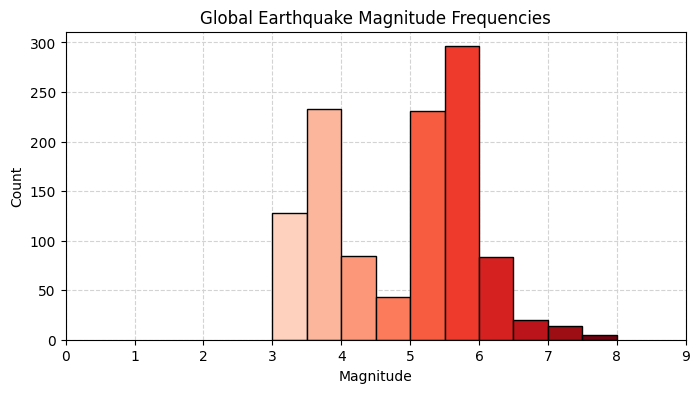

In [235]:
# histogram of magnitudes
min_mag = df['magnitude'].min()
max_mag = df['magnitude'].max()
bins = np.arange(min_mag, max_mag + 0.5, 0.5)

fig, ax = plt.subplots(figsize=(8, 4))
n, bins, patches = ax.hist(df['magnitude'], edgecolor = 'black', bins = bins, zorder = 2)
normalized = plt.Normalize(min_mag - 1, max_mag)
cmap = plt.cm.Reds
for bin, patch in zip(bins, patches):
    color = cmap(normalized(bin))
    patch.set_facecolor(color)

ax.set_title('Global Earthquake Magnitude Frequencies')
ax.set_xlabel("Magnitude")
ax.set_ylabel('Count')
ax.set_xticks(np.arange(0,10,1))
ax.grid(linestyle = '--', color = 'lightgrey', zorder = 1)
plt.show()

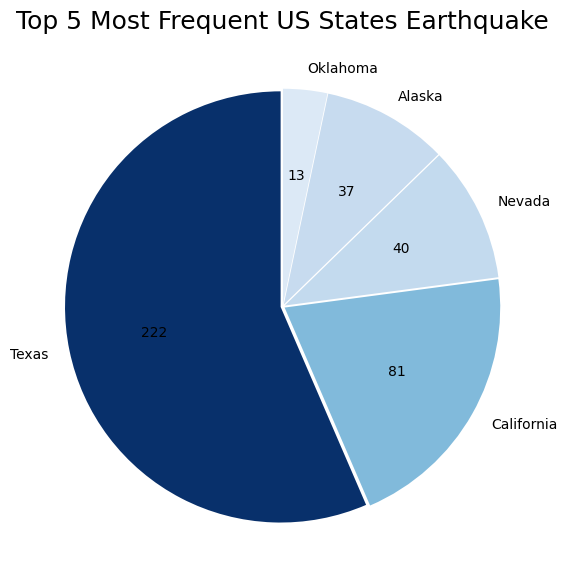

In [9]:
# function for calculating pie chart counts
def func(pct, allvalues):
    absolute = int(round(pct / 100. * sum(allvalues)))  # Calculate the absolute count
    return f'{absolute}'

us_places = usa['subnational'].value_counts()
top_5 = us_places.head(5)
norm = plt.Normalize(top_5.min()-30 , top_5.max()-20)
colors = plt.cm.Blues(norm(top_5.values))
explode = [0.01] * len(top_5)

plt.figure(figsize = (7, 7))
plt.pie(top_5, labels = top_5.index, startangle = 90, colors = colors, autopct = lambda pct: func(pct, top_5.values), explode = explode, labeldistance = 1.1, textprops={'fontsize': 10})
plt.title('Top 5 Most Frequent US States Earthquake', fontsize = 18)
plt.show()

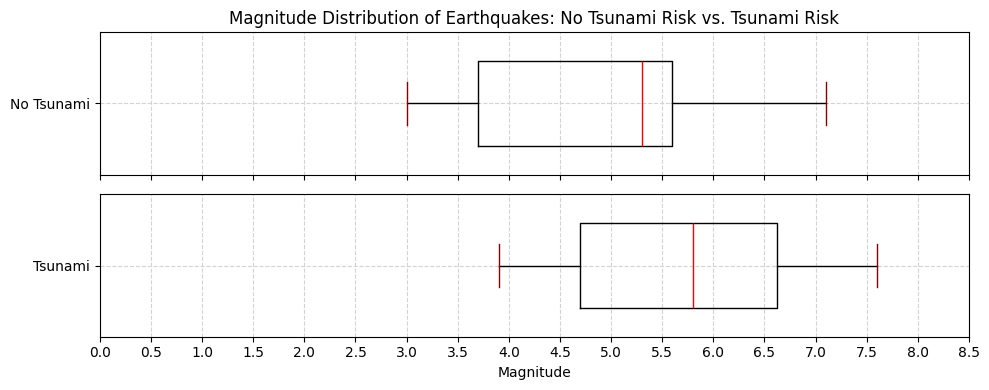

In [177]:
# distribution of earthquake magnitudes causing tsunamis versus those that didn't
tsu = df[df['tsunami'] == 1]
notsu = df[df['tsunami'] != 1]

fig, axes = plt.subplots(2, 1, figsize = (10,4), sharex = True)

axes[0].boxplot(notsu['magnitude'], vert = False, widths = 0.6, capprops = dict(color='darkred'), medianprops = dict(color='red'))
axes[0].set_title('Magnitude Distribution of Earthquakes: No Tsunami Risk vs. Tsunami Risk')
axes[0].grid(True, linestyle = '--', color = 'lightgrey')
axes[0].set_yticks([1])
axes[0].set_yticklabels(['No Tsunami'])
axes[0].set_xticks(np.arange(0,9,0.5))

axes[1].boxplot(tsu['magnitude'], vert = False, widths = 0.6, capprops = dict(color='darkred'), medianprops = dict(color='red'))
axes[1].set_xlabel('Magnitude')
axes[1].set_yticks([1])
axes[1].set_yticklabels(['Tsunami'])
axes[1].grid(True, linestyle = '--', color = 'lightgrey')
axes[1].set_xticks(np.arange(0,9,0.5))

plt.tight_layout()
plt.show()

## Visualizing US Earthquakes

In [3]:
# convert us data to geoDF and handle missingness
usa = gpd.GeoDataFrame(usa, geometry = gpd.points_from_xy(usa['longitude'], usa['latitude'], crs = "EPSG:4269"))
usa.loc[usa['subnational'].isna() & usa['title'].str.contains('CA'), 'subnational'] = 'California'

# state shape files (https://www2.census.gov/geo/tiger/TIGER2024/)
states = gpd.read_file("~/Desktop/GeoSpatial/data/tl_2024_us_state/tl_2024_us_state.shp")

# merged (USA/states) files for density plotting
merged = gpd.sjoin(usa, states, how = 'inner', predicate = 'intersects')

# faults map (https://www.usgs.gov/programs/earthquake-hazards/faults)
faults = gpd.read_file("~/Desktop/GeoSpatial/data/Qfaults_GIS/SHP/Qfaults_US_Database.shp")
faults = faults.to_crs("EPSG:4269")

In [4]:
# ensure all files use coordinate reference systems that are the same
print("USA CRS:", usa.crs)
print("States CRS:", states.crs)
print("Merged CRS:", merged.crs)
print("Faults CRS:", faults.crs)

USA CRS: EPSG:4269
States CRS: EPSG:4269
Merged CRS: EPSG:4269
Faults CRS: EPSG:4269


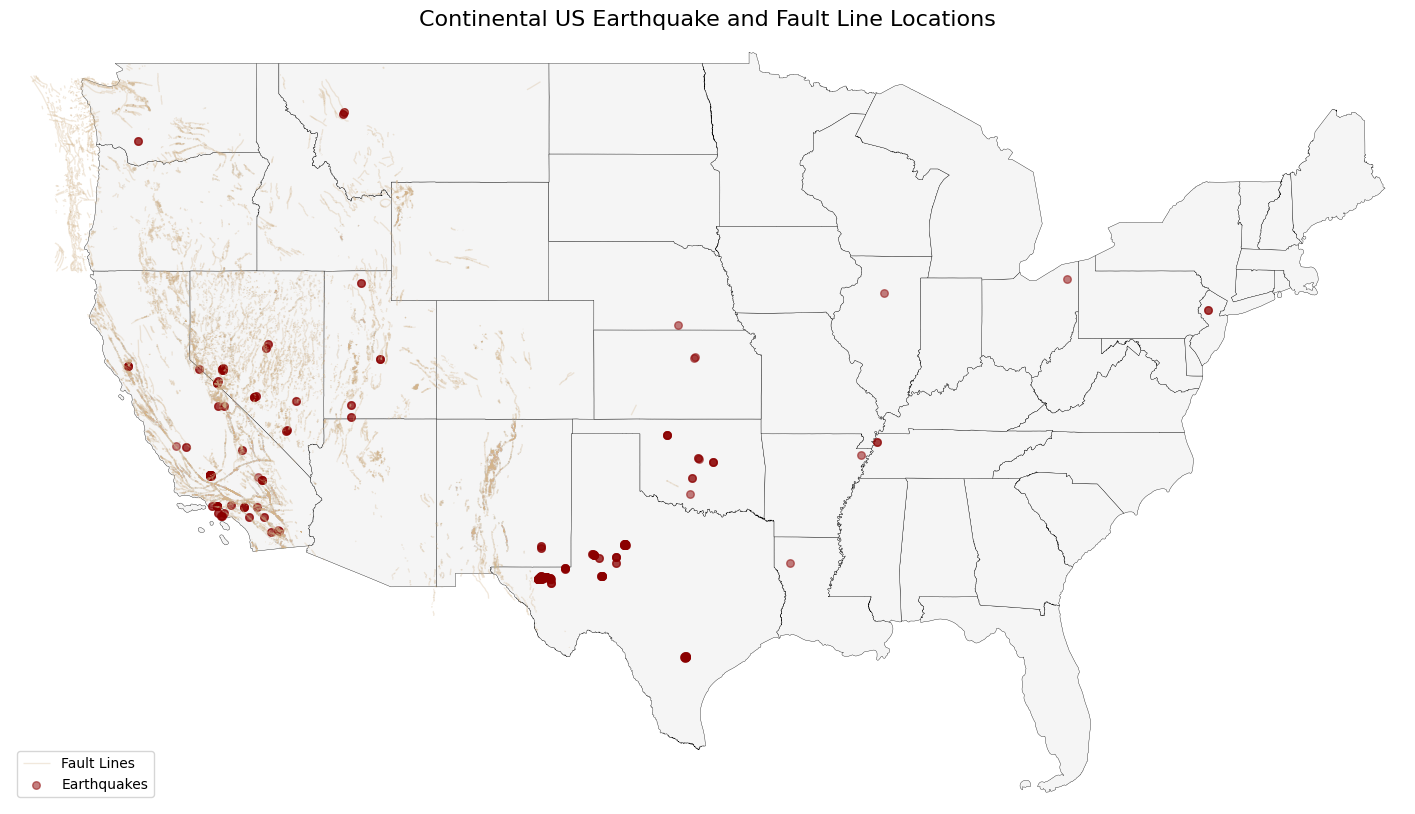

In [5]:
fig, ax = plt.subplots(figsize = (18, 10))
states.plot(ax = ax, linewidth = 0.25, color = 'whitesmoke', edgecolor = 'black')
faults.plot(ax = ax, color = 'tan', linewidth = 0.95, alpha = 0.3, label = 'Fault Lines')
usa.plot(ax = ax, color = 'darkred', markersize = 30, alpha = 0.5, label = 'Earthquakes')
ax.set_aspect('auto')

for spine in ax.spines.values():
    spine.set_visible(False)

plt.title('Continental US Earthquake and Fault Line Locations', fontsize = 16)
plt.xlim(-128, -66)
plt.ylim(24, 50)
plt.xticks([])
plt.yticks([])
plt.legend(loc = 'lower left')
plt.show()

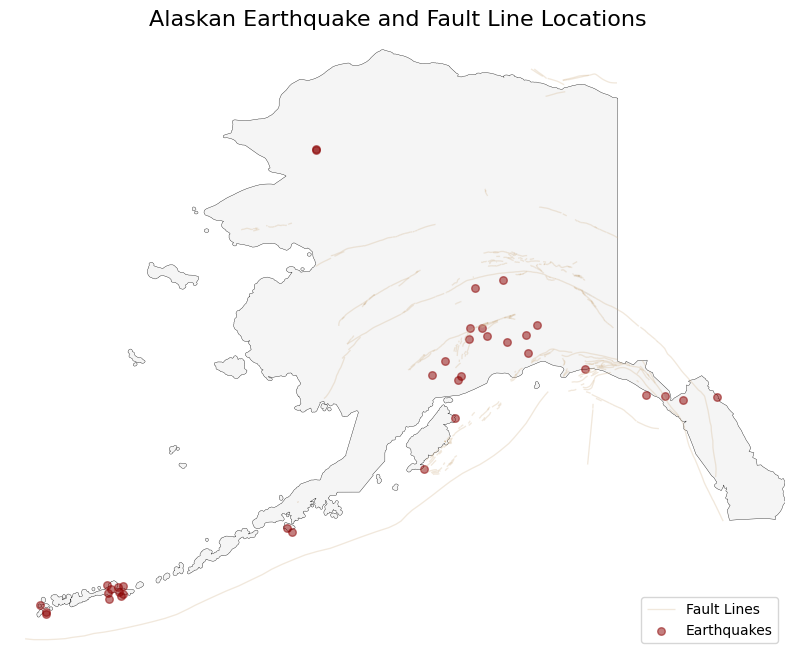

In [6]:
fig, ax = plt.subplots(figsize = (10, 8))
states.plot(ax = ax, linewidth = 0.25, color = 'whitesmoke', edgecolor = 'black')
faults.plot(ax = ax, color = 'tan', linewidth = 0.95, alpha = 0.3, label = 'Fault Lines')
usa.plot(ax = ax, color = 'darkred', markersize = 30, alpha = 0.5, label = 'Earthquakes')
ax.set_aspect('auto')
for spine in ax.spines.values():
    spine.set_visible(False)

plt.title('Alaskan Earthquake and Fault Line Locations', fontsize = 16)
plt.xlim(-181, -130)
plt.ylim(50, 72)
plt.xticks([])
plt.yticks([])
plt.legend(loc = 'lower right')
plt.show()

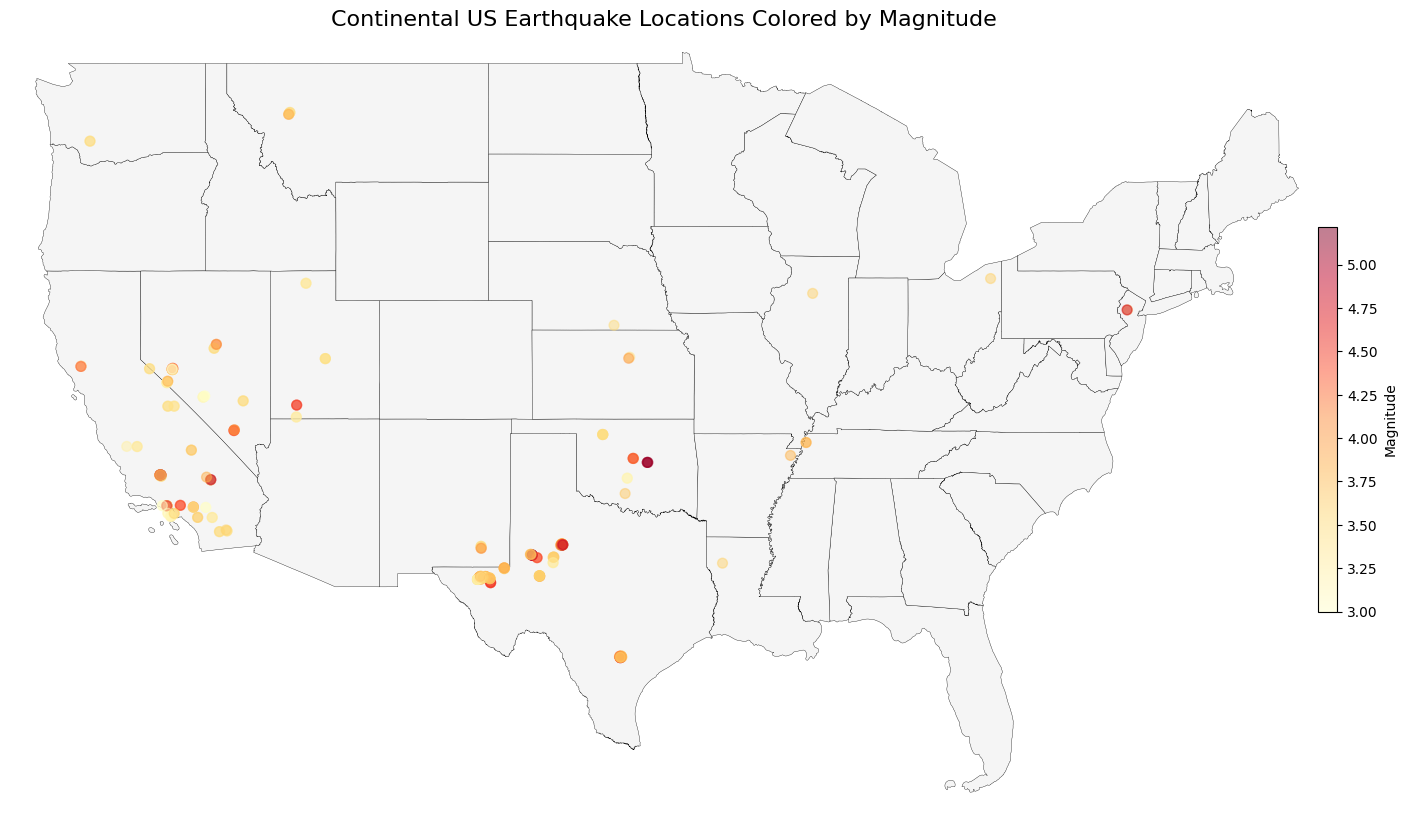

In [7]:
fig, ax = plt.subplots(figsize=(18, 10))
states.plot(ax = ax, linewidth = 0.25, color = 'whitesmoke', edgecolor = 'black')
scatter = ax.scatter(usa['longitude'], usa['latitude'], c = usa['magnitude'], cmap = 'YlOrRd', s = 50, alpha = 0.5)
ax.set_aspect('auto')
cbar = fig.colorbar(scatter, ax = ax, shrink = 0.5, pad = 0.0002)
cbar.set_label('Magnitude')

plt.subplots_adjust(right = 0.98)

for spine in ax.spines.values():
    spine.set_visible(False)

plt.title('Continental US Earthquake Locations Colored by Magnitude', fontsize = 16)
plt.xlim(-126, -66)
plt.ylim(24, 50)
plt.xticks([])
plt.yticks([])
plt.show()

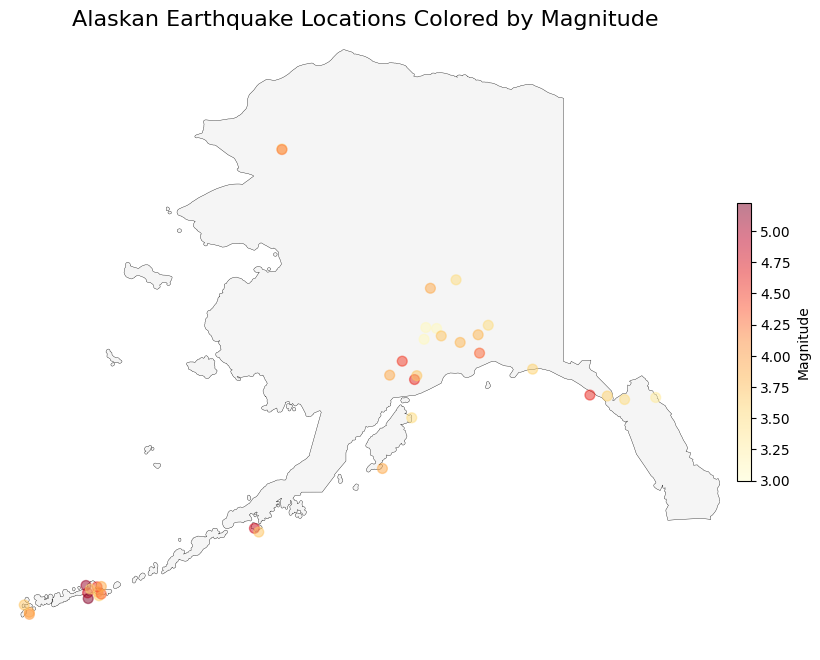

In [8]:
fig, ax = plt.subplots(figsize=(10, 8))
states.plot(ax = ax, linewidth = 0.25, color = 'whitesmoke', edgecolor = 'black')
scatter = ax.scatter(usa['longitude'], usa['latitude'], c = usa['magnitude'], cmap = 'YlOrRd', s = 50, alpha = 0.5)
ax.set_aspect('auto')
cbar = fig.colorbar(scatter, ax = ax, shrink = 0.45, pad = 0.02)
cbar.set_label('Magnitude')

plt.subplots_adjust(right = 0.98)

for spine in ax.spines.values():
    spine.set_visible(False)

plt.title('Alaskan Earthquake Locations Colored by Magnitude', fontsize = 16)
plt.xlim(-180, -130)
plt.ylim(50, 72)
plt.xticks([])
plt.yticks([])
plt.show()

In [9]:
usa['felt'].describe()

count       423.000000
mean       1054.879433
std        9391.759539
min           0.000000
25%           0.000000
50%           4.000000
75%          53.000000
max      183786.000000
Name: felt, dtype: float64

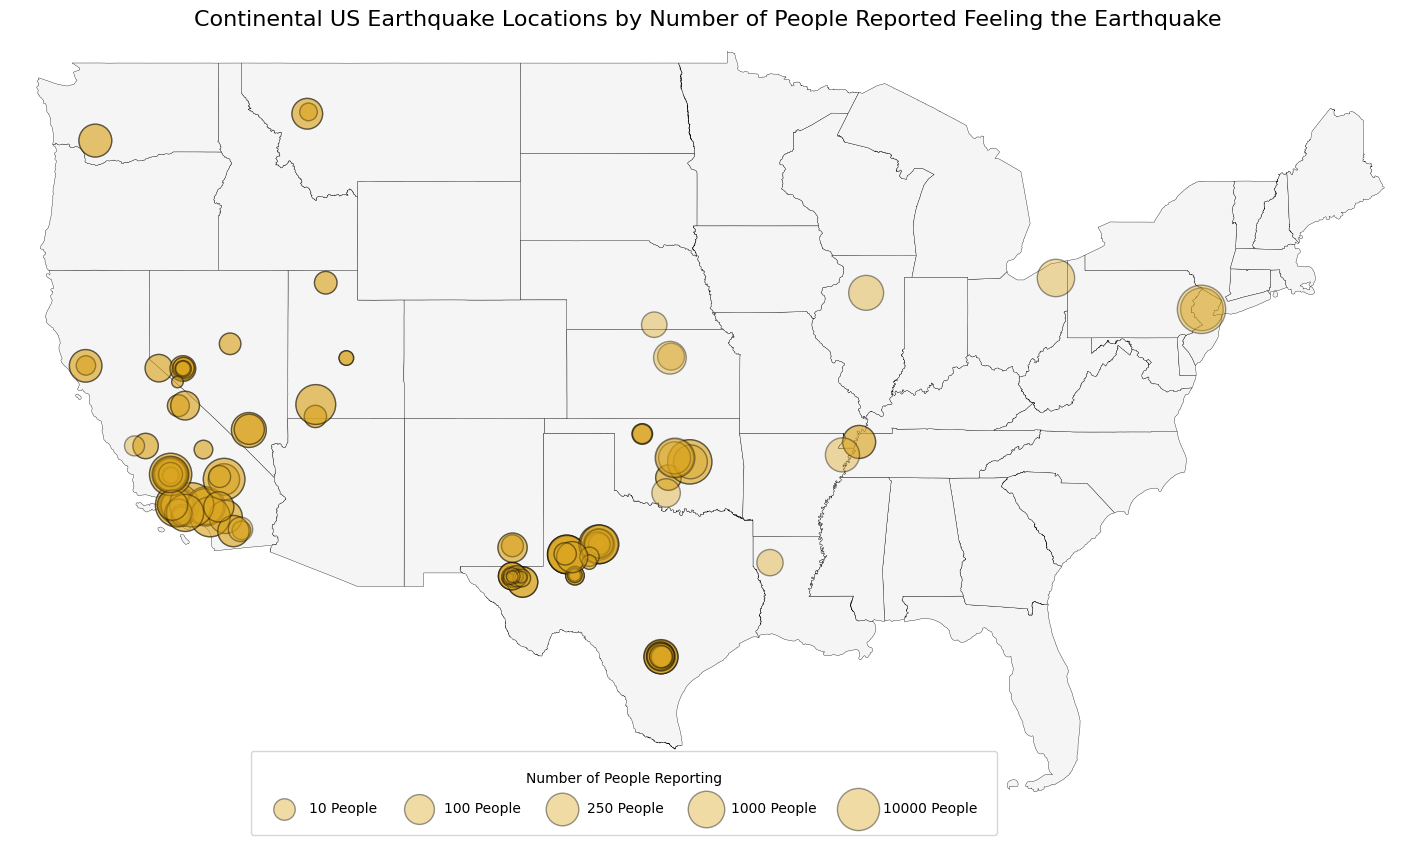

In [10]:
fig, ax = plt.subplots(figsize=(18, 10))
states.plot(ax = ax, linewidth = 0.25, color = 'whitesmoke', edgecolor = 'black')
scatter = ax.scatter(usa['longitude'], usa['latitude'], color = 'goldenrod', edgecolor = 'black', s = np.log1p(usa['felt']) * 100, alpha = 0.4)
ax.set_aspect('auto')

for spine in ax.spines.values():
    spine.set_visible(False)

plt.title('Continental US Earthquake Locations by Number of People Reported Feeling the Earthquake', fontsize = 16)
plt.xlim(-126, -66)
plt.ylim(24, 50)
plt.xticks([])
plt.yticks([])

sample_distances = [10, 100, 250, 1000, 10000]
sample_sizes = np.log1p(sample_distances) * 100

for distance, size in zip(sample_distances, sample_sizes):
    ax.scatter([], [], s = size, label = f'{distance} People', color = 'goldenrod', edgecolor = 'black', alpha = 0.4)

plt.legend(title = "Number of People Reporting", loc = 'lower center', bbox_to_anchor = (0.44, -0.05), ncol = 5, borderpad=1.4, labelspacing=1.2)
plt.show()

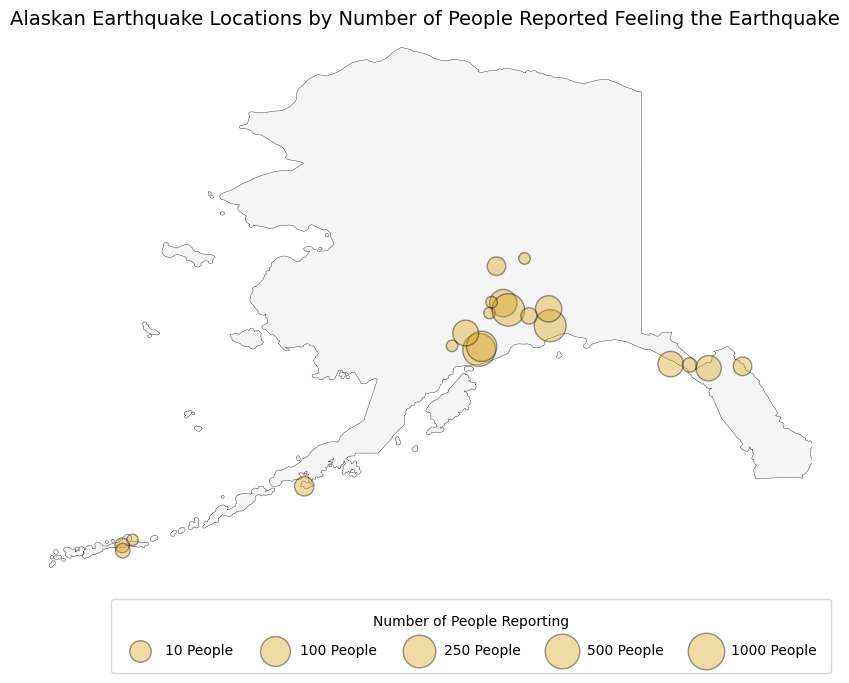

In [11]:
fig, ax = plt.subplots(figsize=(10, 8))
states.plot(ax = ax, linewidth = 0.25, color = 'whitesmoke', edgecolor = 'black')
scatter = ax.scatter(usa['longitude'], usa['latitude'], color = 'goldenrod', edgecolor = 'black', s = np.log1p(usa['felt']) * 100, alpha = 0.4)
ax.set_aspect('auto')

for spine in ax.spines.values():
    spine.set_visible(False)

plt.title('Alaskan Earthquake Locations by Number of People Reported Feeling the Earthquake', fontsize = 14)
plt.xlim(-180, -130)
plt.ylim(48, 72)
plt.xticks([])
plt.yticks([])

sample_distances = [10, 100, 250, 500, 1000]
sample_sizes = np.log1p(sample_distances) * 100

for distance, size in zip(sample_distances, sample_sizes):
    ax.scatter([], [], s = size, label = f'{distance} People', color = 'goldenrod', edgecolor = 'black', alpha = 0.4)

plt.legend(title = "Number of People Reporting", loc = 'lower center', bbox_to_anchor = (0.56, -0.05), ncol = 5, borderpad = 1.1, labelspacing = 1.1)
plt.show()

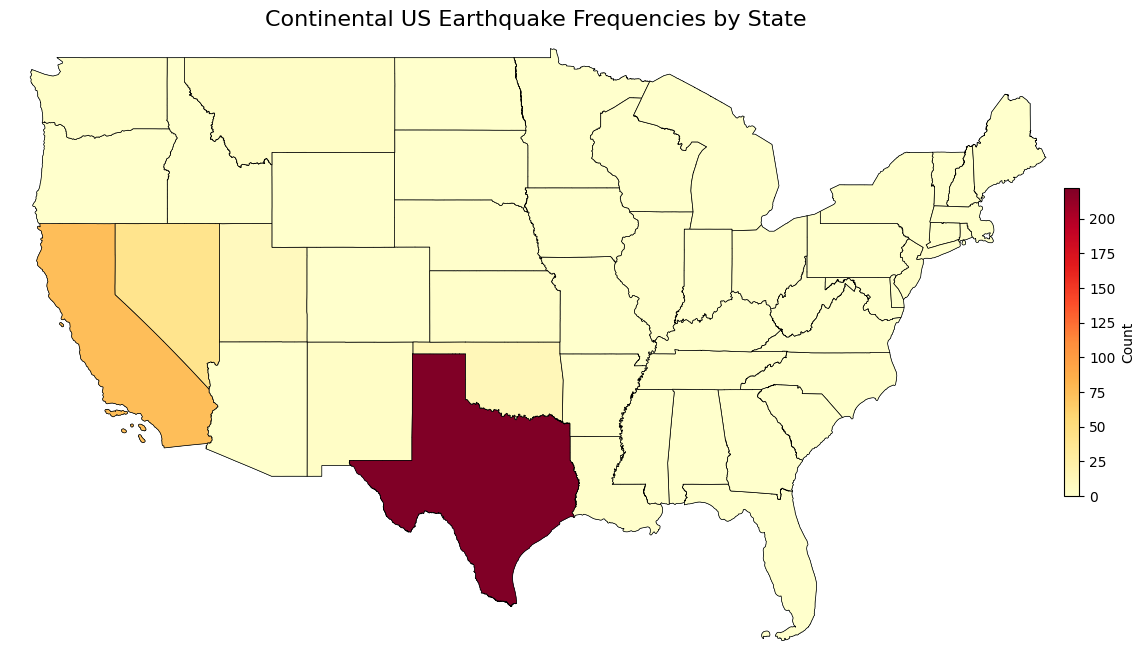

In [12]:
counts = merged['subnational'].value_counts().reset_index()
counts.columns = ['state', 'count']
state_counts = states.merge(counts, left_on = 'NAME', right_on ='state', how = 'left')
state_counts['count'] = state_counts['count'].fillna(0)

plt.figure(figsize=(16, 8))
ax = plt.gca()
state_counts.plot(ax = ax, linewidth = 0.2, edgecolor = 'black')
state_counts.plot(column = 'count', ax = plt.gca(), cmap = "YlOrRd", linewidth = 0.5, edgecolor = 'black')
cbar = plt.colorbar(ax.collections[1], ax = ax, shrink = 0.5, pad = 0.002)
cbar.set_label('Count')
ax.set_aspect('auto')

for spine in ax.spines.values():
    spine.set_visible(False)

plt.title("Continental US Earthquake Frequencies by State", fontsize = 16)
plt.xlim(-126, -66)
plt.ylim(24, 50)
plt.xticks([])
plt.yticks([])
plt.xlabel(None)
plt.ylabel(None)
plt.show()

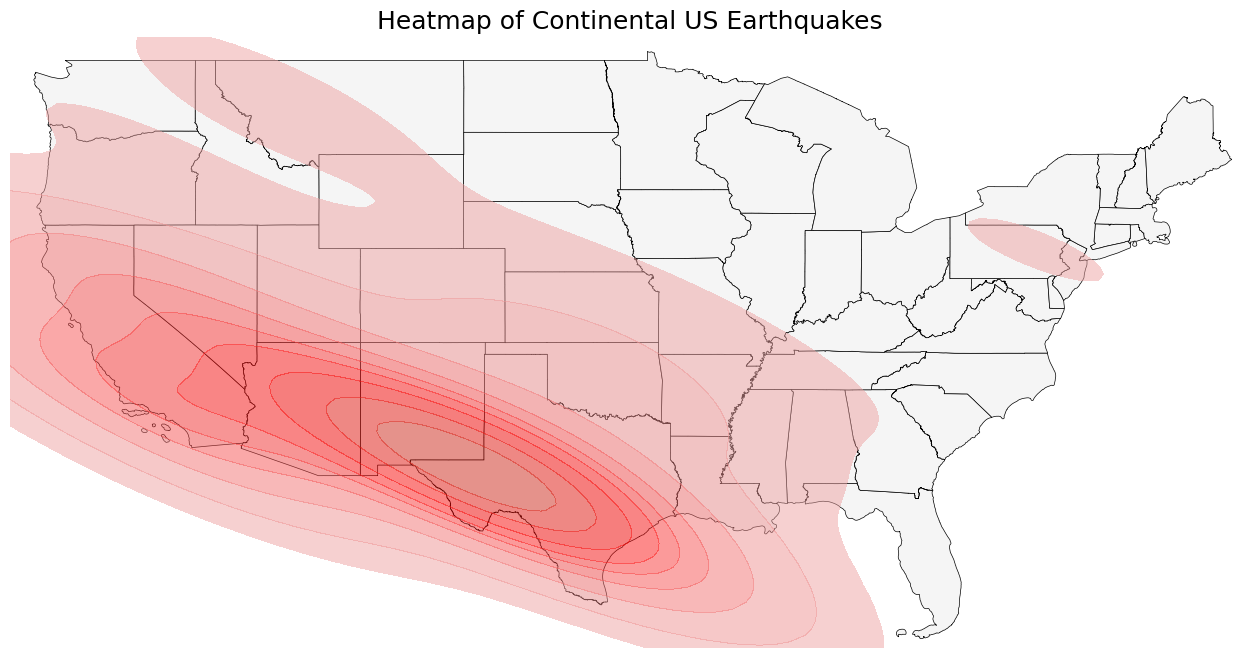

In [13]:
from matplotlib.colors import LinearSegmentedColormap

plt.figure(figsize = (16,10))
custom_cmap = LinearSegmentedColormap.from_list("custom_reds", ["#EDA8A8", "#FF0000", "#CD3B2B"])
states.plot(ax = plt.gca(), linewidth = 0.5, edgecolor = 'black', color = 'whitesmoke')
sns.kdeplot(x = usa['longitude'], y = usa['latitude'], fill = True, cmap = custom_cmap, alpha = 0.5, levels = 10)
ax.set_aspect('auto')

plt.title("Heatmap of Continental US Earthquakes", fontsize = 18)
plt.xlim(-126, -66)
plt.ylim(24, 50)
plt.xticks([])
plt.yticks([])
plt.xlabel(None)
plt.ylabel(None)

ax = plt.gca()
for spine in ax.spines.values():
    spine.set_visible(False)
    
plt.show()

## Tsunami Prediction: Logistic Regression & Random Forest Classifier

In [209]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

from statsmodels.stats.outliers_influence import variance_inflation_factor

In [15]:
df = gpd.GeoDataFrame(df, geometry = gpd.points_from_xy(df['longitude'], df['latitude'], crs = "EPSG:4269"))
print(df.shape)
print(df.columns)
print(df.crs)

(1137, 44)
Index(['id', 'magnitude', 'type', 'title', 'date', 'time', 'updated', 'url',
       'detailUrl', 'felt', 'cdi', 'mmi', 'alert', 'status', 'tsunami', 'sig',
       'net', 'code', 'ids', 'sources', 'types', 'nst', 'dmin', 'rms', 'gap',
       'magType', 'geometryType', 'depth', 'latitude', 'longitude', 'place',
       'distanceKM', 'placeOnly', 'location', 'continent', 'country',
       'subnational', 'city', 'locality', 'postcode', 'what3words', 'timezone',
       'locationDetails', 'geometry'],
      dtype='object')
EPSG:4269


#### Preprocessing: Calculate Earthquake Distances to Coastline: Overall, Latitude, and Longitude Distances

In [16]:
# coastline data (https://www.naturalearthdata.com/downloads/10m-physical-vectors/10m-coastline/)
coast = gpd.read_file("~/Desktop/GeoSpatial/data/ne_10m_coastline/ne_10m_coastline.shp")
coast = coast.to_crs("EPSG:4269")
print(coast.shape)
print(coast.columns)
print(coast.crs)

(4133, 4)
Index(['featurecla', 'scalerank', 'min_zoom', 'geometry'], dtype='object')
EPSG:4269


In [17]:
import pandas as pd
import numpy as np
from shapely.ops import nearest_points
from scipy.spatial import cKDTree
from pyproj import CRS, Transformer

def calculate_nearest_coast_distances(df, coast):
    """
    Calculate distances from earthquake points to nearest coastline efficiently using spatial indexing and projections.

    - Spatial Indexing: Organize points into tree structure (KD-tree) for nearest neighbor search: O(n*log(m)) 
      n = # earthquakes, m = # coast points.
    - Projection: Uses point-specific "distance preserving" or "azimuthal equidistant projection" centered on each earthquake 
      point. This handles the spherical nature of the globe.
    """
    df_original = df.copy()
    coast_original = coast.copy()
    
    # individual distance preserving projection for each point
    def project_point(point):
        lat = point.y
        long = point.x
        proj_string = f'+proj=aeqd +lat_0={lat} +lon_0={long} +datum=WGS84 +units=m' # create projection centered on this point
        proj_crs = CRS.from_string(proj_string)

        # transform from geographic to azimuthal equidistant (EPSG:4269 -> point-specific aeqd)
        transformer = Transformer.from_crs(CRS.from_epsg(4269), proj_crs, always_xy = True)

        return transformer
    
    coast_points = []
    
    # sample points ~100km for arrays of coordinates for KD-tree
    for line in coast_original.geometry:
        distances = np.linspace(0, line.length, num = max(2, int(line.length/100000)))
        points = [line.interpolate(dist) for dist in distances]
        coast_points.extend([(pnt.x, pnt.y) for pnt in points])
    
    coast_coords = np.array(coast_points)
    earthquake_coords = np.array([(point.x, point.y) for point in df_original.geometry])
    tree = cKDTree(coast_coords) # KD-tree: efficient nearest neighbor search

    results = []
    
    for ind, earthquake in enumerate(df_original.geometry):
        distances, indices = tree.query(earthquake_coords[ind], k = 10) # get 10 nearest coastline points from KD-tree
        transformer = project_point(earthquake) # projection centered on earthquake point
        eq_x, eq_y = transformer.transform(earthquake.x, earthquake.y) # transform earthquake point
        
        min_dist = float('inf')
        nearest_point = None

        # check candidates for true nearest
        for i, coast_ind in enumerate(indices):
            coast_point = coast_coords[coast_ind]
            coast_x, coast_y = transformer.transform(coast_point[0], coast_point[1])
        
            # calc exact distance
            dist = np.sqrt((eq_x - coast_x)**2 + (eq_y - coast_y)**2)
            
            if dist < min_dist:
                min_dist = dist
                nearest_point = coast_point
        
        results.append({
            'dist_coast': min_dist / 1000,  # KM
            'dist_coast_lat': nearest_point[1],
            'dist_coast_long': nearest_point[0]
        })
    
    results_df = pd.DataFrame(results)
    df_with_distances = df_original.copy()
    df_with_distances['dist_coast'] = results_df['dist_coast']
    df_with_distances['dist_coast_lat'] = results_df['dist_coast_lat']
    df_with_distances['dist_coast_long'] = results_df['dist_coast_long']
    
    return df_with_distances

In [18]:
df_w_dists = calculate_nearest_coast_distances(df, coast)

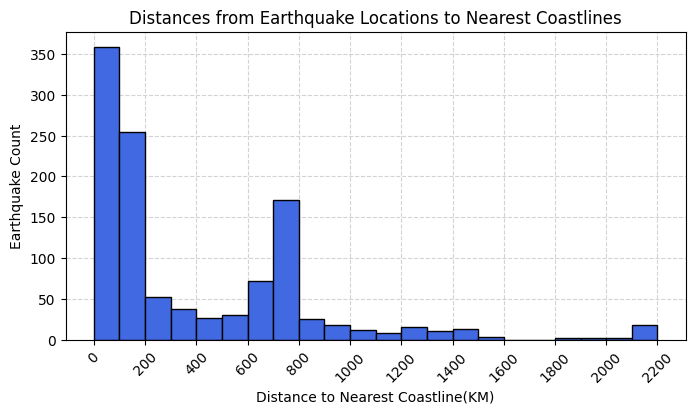

In [19]:
bin_edges = np.arange(0, 2201, 100)

fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(df_w_dists['dist_coast'], bins = bin_edges, edgecolor = 'black', color = 'royalblue', zorder = 2)
ax.set_title('Distances from Earthquake Locations to Nearest Coastlines')
ax.set_xlabel('Distance to Nearest Coastline(KM)')
ax.set_ylabel('Earthquake Count')
ax.set_xticks(np.arange(0,2201, 200))
ax.tick_params(axis = 'x', rotation = 45)
ax.grid(linestyle = '--', color = 'lightgrey', zorder = 1)
plt.show()

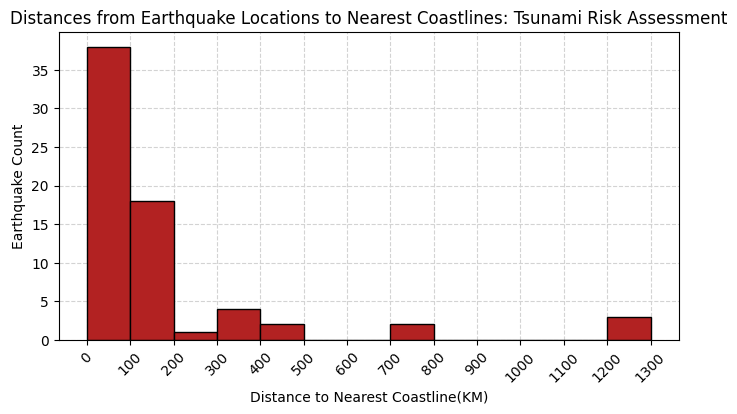

In [20]:
dft = df_w_dists[df_w_dists['tsunami'] == 1]
bin_edges = np.arange(0, 1301, 100)

fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(dft['dist_coast'], bins = bin_edges, edgecolor = 'black', color = 'firebrick', zorder = 2)
ax.set_title('Distances from Earthquake Locations to Nearest Coastlines: Tsunami Risk Assessment')
ax.set_xlabel('Distance to Nearest Coastline(KM)')
ax.set_ylabel('Earthquake Count')
ax.set_xticks(np.arange(0,1301, 100))
ax.tick_params(axis = 'x', rotation = 45)
ax.grid(linestyle = '--', color = 'lightgrey', zorder = 1)
plt.show()

### Features to Consider

#### Numerical Features:
- magnitude: The strength of the earthquake on the Richter scale.
- felt: Number of people who reported feeling the earthquake.
- cdi: Community Determined Intensity, how strongly the event was felt.
- mmi: Modified Mercalli Intensity, scale used to measure earthquake intensity.
- nst: Number of seismic stations that recorded the event.
- dmin: Minimum distance to the earthquake event.
- sig: Significance of the earthquake, based on magnitude and impact.
- rms: Root mean square of signal, used to measure earthquake intensity.
- depth: Depth of the earthquake in kilometers.
- latitude: Latitude of the earthquake's epicenter.
- longitude: Longitude of the earthquake's epicenter.
- distanceKM: Distance from the nearest populated place in kilometers.
- dist_coast: distance to nearest coastline
- dist_coast_lat: latitude distance from epicenter to coastline
- dist_coast_long: longitude distance from epicenter to coastline

#### Categorical Features:
- alert: Alert level (green, yellow, orange, red).
- continent: Continent where the earthquake occurred.

#### Target:
- tsunami: Tsunami risk flag (0 = no risk, 1 = risk).

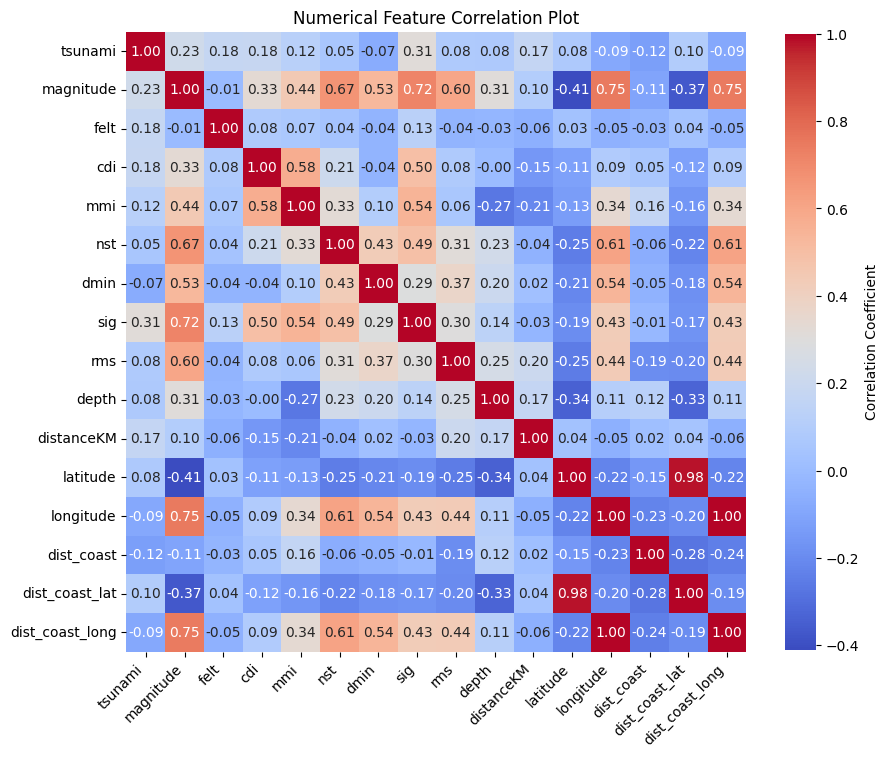

In [32]:
corr_cols = ['tsunami', 'magnitude', 'felt', 'cdi', 'mmi', 'nst', 'dmin', 'sig', 'rms', 'depth', 'distanceKM', 'latitude', 'longitude', 'dist_coast', 'dist_coast_lat', 'dist_coast_long']
corr_matrix = df_w_dists[corr_cols].corr()

fig, ax = plt.subplots(figsize = (10,10))
sns.heatmap(corr_matrix, annot = True, fmt = '.2f', cmap = 'coolwarm', square = True, cbar_kws = {"shrink": .8, "label": 'Correlation Coefficient'})
ax.set_title("Numerical Feature Correlation Plot")
plt.xticks(rotation = 45, ha = 'right')
plt.show()

### Assess Multicollinearity and Feature Selection

In [140]:
# assess multicollinearity/VIF (potential inflation of standard errors on coefficients)
features =  ['magnitude', 'felt', 'cdi', 'mmi', 'nst', 'dmin', 'sig', 'rms', 'depth', 'distanceKM', 'latitude', 'longitude', 'dist_coast', 'dist_coast_lat', 'dist_coast_long']
num_features = df_w_dists[features]
vif = pd.DataFrame()
vif['feature'] = num_features.columns
vif['VIF'] = [variance_inflation_factor(num_features.values, i) for i in range(num_features.shape[1])]
print(vif)

# Notes: 
# magnitude is high: correlated with mmi, sig, and a few others (but key predictor)
# lat and long must go / are redundant

            feature          VIF
0         magnitude    48.608319
1              felt     1.054102
2               cdi     4.126245
3               mmi    27.718803
4               nst     5.157891
5              dmin     2.712390
6               sig     8.654867
7               rms     8.349661
8             depth     2.223121
9        distanceKM     2.263183
10         latitude   186.689033
11        longitude  1674.285170
12       dist_coast     6.330295
13   dist_coast_lat   180.821868
14  dist_coast_long  1699.365398


In [141]:
features =  ['magnitude', 'felt', 'cdi', 'nst', 'dmin', 'rms', 'depth', 'distanceKM', 'dist_coast', 'dist_coast_lat', 'dist_coast_long']
num_features = df_w_dists[features]
vif = pd.DataFrame()
vif['feature'] = num_features.columns
vif['VIF'] = [variance_inflation_factor(num_features.values, i) for i in range(num_features.shape[1])]
print(vif)

# Notes: 
# much better

            feature        VIF
0         magnitude  20.656549
1              felt   1.027537
2               cdi   2.926447
3               nst   5.038472
4              dmin   2.562024
5               rms   7.856558
6             depth   1.548210
7        distanceKM   2.184010
8        dist_coast   2.252770
9    dist_coast_lat   2.911706
10  dist_coast_long   2.025732


### Data Splitting and Preprocessing

In [163]:
X = df_w_dists.drop('tsunami', axis = 1)
y = df_w_dists['tsunami']

# 70 train / 30 test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify = y, random_state = 33)

cat_cols = ['alert', 'continent']
baseline_num_cols = ['magnitude', 'felt', 'cdi', 'nst', 'dmin', 'rms', 'depth', 'distanceKM']
aug_num_cols = ['magnitude', 'felt', 'cdi', 'nst', 'dmin', 'rms', 'depth', 'distanceKM', 'dist_coast', 'dist_coast_lat', 'dist_coast_long']

# preprocess data
base_preprocessor = ColumnTransformer (
    transformers = [
        ('num', StandardScaler(), baseline_num_cols),
        ('cat', OneHotEncoder(handle_unknown = 'ignore'), cat_cols)
    ]
)
aug_preprocessor = ColumnTransformer (
    transformers = [
        ('num', StandardScaler(), aug_num_cols),
        ('cat', OneHotEncoder(handle_unknown = 'ignore'), cat_cols)
    ]
)
print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

Training set size: (795, 46)
Test set size: (342, 46)


### Model Search Grid, Pipeline, and GridSearchCV Set Up

In [269]:
log_reg = LogisticRegression(class_weight = 'balanced', random_state = 33, max_iter = 1000, tol = 1e-3)
ran_for = RandomForestClassifier(class_weight = 'balanced', random_state = 33)

# search grids
lr_grid = {
    'classifier__C': [0.001, 0.01, 0.1, 1],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['saga', 'liblinear']
}
rf_grid = {
    'classifier__n_estimators': [50, 100, 150, 200, 300],
    'classifier__max_depth': [10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10]
}

# baseline pipelines
base_lr_pipeline = Pipeline([
    ('preprocessor', base_preprocessor),
    ('classifier', log_reg)
])
base_rf_pipeline = Pipeline([
    ('preprocessor', base_preprocessor),
    ('classifier', ran_for)
])
# geospatial augmented pipelines
aug_lr_pipeline = Pipeline([
    ('preprocessor', aug_preprocessor),
    ('classifier', log_reg)
])
aug_rf_pipeline = Pipeline([
    ('preprocessor', aug_preprocessor),
    ('classifier', ran_for)
])

# set up k-fold cross validation on recall with grid hyperparameter search
base_log_regCV = GridSearchCV(base_lr_pipeline, lr_grid, cv = 5, scoring = 'recall', n_jobs = -1)
base_ran_forCV = GridSearchCV(base_rf_pipeline, rf_grid, cv = 5, scoring = 'recall', n_jobs = -1)

aug_log_regCV = GridSearchCV(aug_lr_pipeline, lr_grid, cv = 5, scoring = 'recall', n_jobs = -1)
aug_ran_forCV = GridSearchCV(aug_rf_pipeline, rf_grid, cv = 5, scoring = 'recall', n_jobs = -1)

### Fit Models to Training Data

In [270]:
base_log_regCV.fit(X_train, y_train)
base_ran_forCV.fit(X_train, y_train)

aug_log_regCV.fit(X_train, y_train)
aug_ran_forCV.fit(X_train, y_train)

/Users/connormcmanigal/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/connormcmanigal/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['magnitude',
                                                                          'felt',
                                                                          'cdi',
                                                                          'nst',
                                                                          'dmin',
                                                                          'rms',
                                                                          'depth',
                                                                          'distanceKM',
                                                                          'dist_coast',
                                                                          'dist_coast_lat',
                                                                          'dist_coast_long']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['alert',
                                                                          'continent'])])),
                                       ('classifier',
                                        RandomForestClassifier(class_weight='balanced',
                                                               random_state=33))]),
             n_jobs=-1,
             param_grid={'classifier__max_depth': [10, 20, 30],
                         'classifier__min_samples_split': [2, 5, 10],
                         'classifier__n_estimators': [50, 100, 150, 200, 300]},
             scoring='recall')

### Model Training Performance

In [271]:
def print_top_cv_results(grid_search, model_name):
    print(f'{model_name} Top 10 CV Results:')
    cv_scores = grid_search.cv_results_['mean_test_score']
    params = grid_search.cv_results_['params']
    results = list(zip(cv_scores, params))
    sorted_results = sorted(results, key = lambda x: x[0], reverse = True)
    for mean_score, param in sorted_results[:10]:
        print(f'AUC: {mean_score:.4f}, \t Params: {param}')
    print('\n')

In [272]:
print_top_cv_results(base_log_regCV, 'Baseline Logistic Regression')

Baseline Logistic Regression Top 10 CV Results:
AUC: 0.8778, 	 Params: {'classifier__C': 1, 'classifier__penalty': 'l2', 'classifier__solver': 'saga'}
AUC: 0.8778, 	 Params: {'classifier__C': 1, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
AUC: 0.8578, 	 Params: {'classifier__C': 0.1, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
AUC: 0.8578, 	 Params: {'classifier__C': 0.1, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
AUC: 0.8578, 	 Params: {'classifier__C': 1, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
AUC: 0.8578, 	 Params: {'classifier__C': 1, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
AUC: 0.8356, 	 Params: {'classifier__C': 0.1, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
AUC: 0.8356, 	 Params: {'classifier__C': 0.1, 'classifier__penalty': 'l2', 'classifier__solver': 'saga'}
AUC: 0.8133, 	 Params: {'classifier__C': 0.01, 'classifier__penalty': 'l2', 'classifier__solver': 'l

In [273]:
print_top_cv_results(aug_log_regCV, 'Geospatial Augmented Logistic Regression')

Geospatial Augmented Logistic Regression Top 10 CV Results:
AUC: 0.9178, 	 Params: {'classifier__C': 0.001, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
AUC: 0.8956, 	 Params: {'classifier__C': 0.01, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
AUC: 0.8756, 	 Params: {'classifier__C': 0.1, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
AUC: 0.8578, 	 Params: {'classifier__C': 1, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
AUC: 0.8578, 	 Params: {'classifier__C': 1, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
AUC: 0.8578, 	 Params: {'classifier__C': 1, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
AUC: 0.8556, 	 Params: {'classifier__C': 0.1, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
AUC: 0.8556, 	 Params: {'classifier__C': 0.1, 'classifier__penalty': 'l2', 'classifier__solver': 'saga'}
AUC: 0.8556, 	 Params: {'classifier__C': 0.1, 'classifier__penalty': 'l2', 'cl

In [274]:
print_top_cv_results(base_ran_forCV, 'Baseline Random Forest')

Baseline Random Forest Top 10 CV Results:
AUC: 0.6022, 	 Params: {'classifier__max_depth': 20, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 50}
AUC: 0.6022, 	 Params: {'classifier__max_depth': 30, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 50}
AUC: 0.5822, 	 Params: {'classifier__max_depth': 10, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 50}
AUC: 0.5622, 	 Params: {'classifier__max_depth': 20, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 100}
AUC: 0.5622, 	 Params: {'classifier__max_depth': 30, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 100}
AUC: 0.5400, 	 Params: {'classifier__max_depth': 20, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 200}
AUC: 0.5400, 	 Params: {'classifier__max_depth': 20, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 300}
AUC: 0.5400, 	 Params: {'classifier__max_depth': 30, 'classifier__min_samples_split': 10, 'classifie

In [275]:
print_top_cv_results(aug_ran_forCV, 'Geospatial Augmented Random Forest')

Geospatial Augmented Random Forest Top 10 CV Results:
AUC: 0.6511, 	 Params: {'classifier__max_depth': 10, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 100}
AUC: 0.6511, 	 Params: {'classifier__max_depth': 10, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 150}
AUC: 0.6511, 	 Params: {'classifier__max_depth': 10, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 200}
AUC: 0.6511, 	 Params: {'classifier__max_depth': 20, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 100}
AUC: 0.6511, 	 Params: {'classifier__max_depth': 20, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 200}
AUC: 0.6511, 	 Params: {'classifier__max_depth': 30, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 100}
AUC: 0.6511, 	 Params: {'classifier__max_depth': 30, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 200}
AUC: 0.6311, 	 Params: {'classifier__max_depth': 10, 'classifier__min_samples_split':

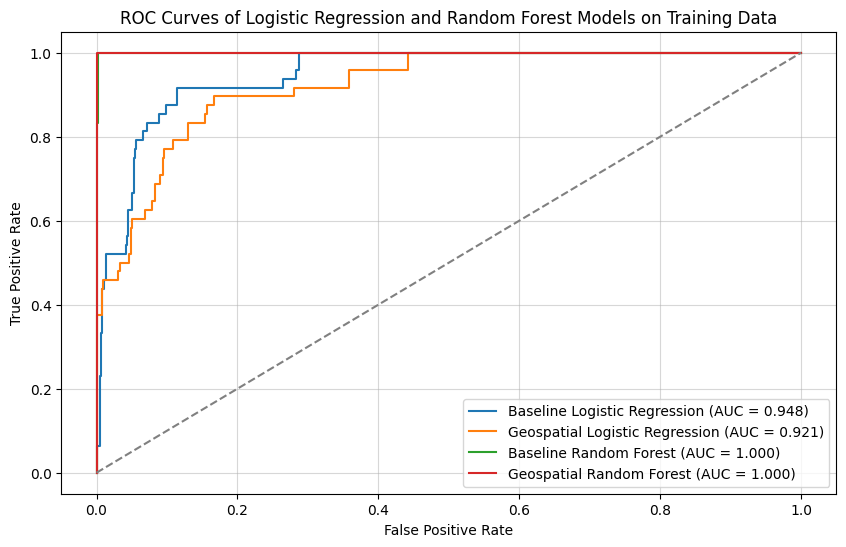

In [276]:
def plot_roc_curve(model, X, y, label):
    y_prob = model.predict_proba(X)[:, 1]
    fpr, tpr, _ = roc_curve(y, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.3f})')

plt.figure(figsize = (10, 6))
plot_roc_curve(base_log_regCV.best_estimator_, X_train, y_train, 'Baseline Logistic Regression')
plot_roc_curve(aug_log_regCV.best_estimator_, X_train, y_train, 'Geospatial Logistic Regression')
plot_roc_curve(base_ran_forCV.best_estimator_, X_train, y_train, 'Baseline Random Forest')
plot_roc_curve(aug_ran_forCV.best_estimator_, X_train, y_train, 'Geospatial Random Forest')

plt.plot([0, 1], [0, 1], linestyle = '--', color = 'gray')
plt.title('ROC Curves of Logistic Regression and Random Forest Models on Training Data')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(alpha=0.5)
plt.legend()
plt.show()

### Model Testing and Performance Metrics

In [277]:
metrics = []
models = {
    'Baseline Logistic Regression': base_log_regCV.best_estimator_,
    'Geospatial Augmented Logistic Regression': aug_log_regCV.best_estimator_,
    'Baseline Random Forest': base_ran_forCV.best_estimator_,
    'Geospatial Augmented Random Forest': aug_ran_forCV.best_estimator_
}

for model_name, model in models.items():
    y_prob = model.predict_proba(X_test)[:, 1]
    y_pred = model.predict(X_test)
    # metrics
    roc = roc_auc_score(y_test, y_prob)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    metrics.append({
        'Model': model_name,
        'ROC-AUC': roc,
        'Precision': prec,
        'Recall': rec,
        'F1 Score': f1
    })

metrics_df = pd.DataFrame(metrics)
metrics_df

,Model,ROC-AUC,Precision,Recall,F1 Score
0,Baseline Logistic Regression,0.936491,0.301887,0.80,0.438356
1,Geospatial Augmented Logistic Regression,0.935870,0.152672,1.00,0.264901
2,Baseline Random Forest,0.996584,1.000000,0.75,0.857143
3,Geospatial Augmented Random Forest,1.000000,1.000000,0.90,0.947368


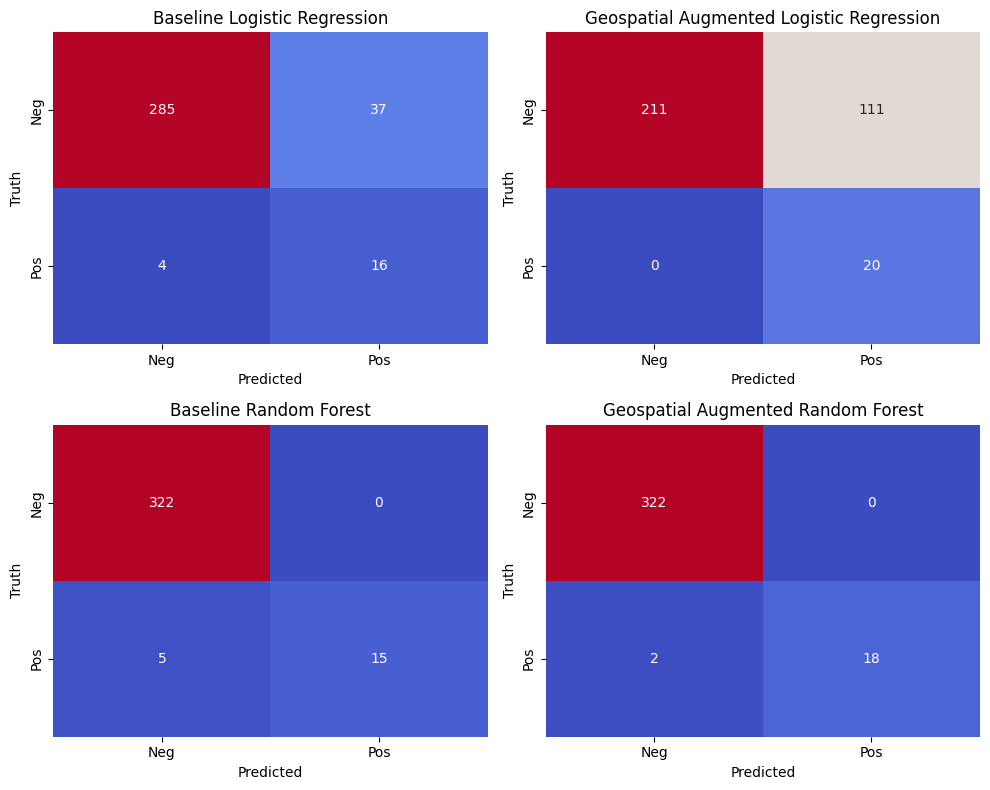

In [278]:
def plot_confusion_matrices(models, X_test, y_test):
    plt.figure(figsize = (10, 8))
    for i, (model_name, model) in enumerate(models.items()):
        y_pred = model.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
        
        plt.subplot(2, 2, i + 1)  # Create a subplot for each model
        sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'coolwarm', cbar = False,
                    xticklabels=['Neg', 'Pos'],
                    yticklabels=['Neg', 'Pos'])
        
        plt.title(model_name)
        plt.xlabel('Predicted')
        plt.ylabel('Truth')

    plt.tight_layout()
    plt.show()

plot_confusion_matrices(models, X_test, y_test)

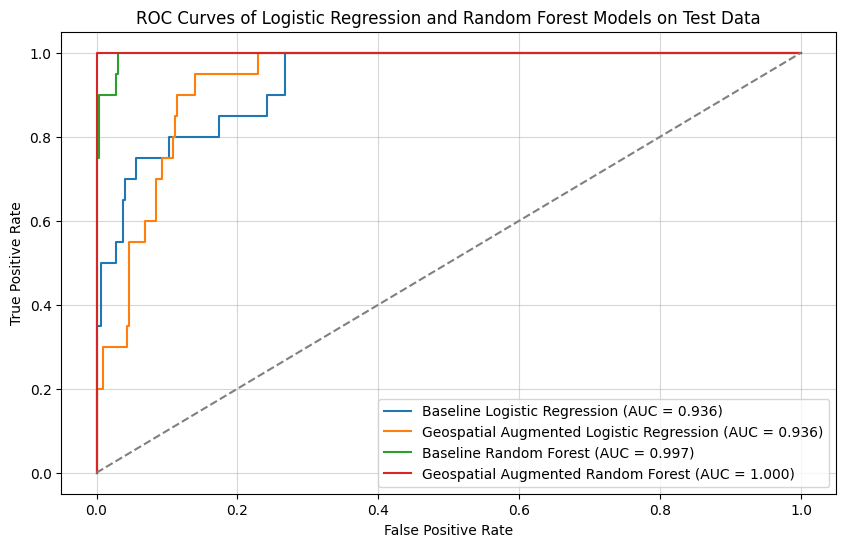

In [279]:
plt.figure(figsize = (10, 6))

for model_name, model in models.items():
    plot_roc_curve(model, X_test, y_test, model_name)

plt.plot([0, 1], [0, 1], linestyle = '--', color = 'gray')
plt.title('ROC Curves of Logistic Regression and Random Forest Models on Test Data')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(alpha=0.5)
plt.legend()
plt.show()

In [285]:
def plot_metrics(metrics_df, metric_name):
    plt.figure(figsize = (8, 4))
    colors = ['cornflowerblue' if 'Logistic Regression' in model else 'firebrick' for model in metrics_df['Model']]
    bars = plt.bar(metrics_df['Model'], metrics_df[metric_name], color = colors, zorder = 2)
    logistic_patch = plt.Line2D([0], [0], color='cornflowerblue', lw=4, label='Logistic Regression')
    random_forest_patch = plt.Line2D([0], [0], color='firebrick', lw=4, label='Random Forest')
    first_words = [model.split()[0] for model in metrics_df['Model']]
    plt.xticks(ticks = np.arange(len(first_words)), labels=first_words, fontsize = 10)
    plt.legend(handles=[logistic_patch, random_forest_patch])
    plt.title(f'{metric_name} by Model')
    plt.xlabel('Model')
    plt.ylabel(metric_name)
    plt.grid(axis = 'y', alpha = 0.5, zorder = 1)
    plt.tight_layout()
    plt.show()

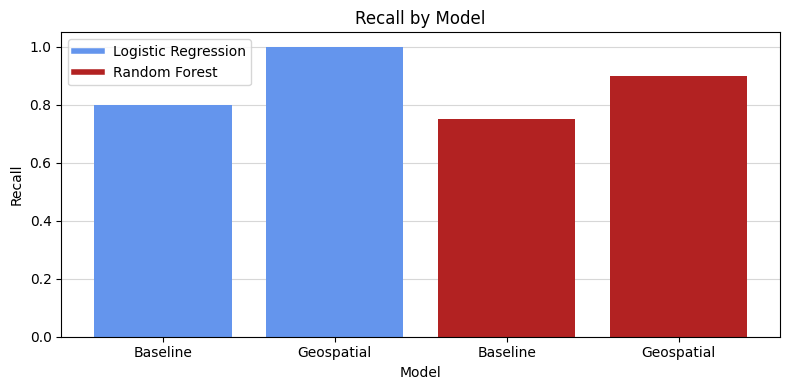

In [286]:
plot_metrics(metrics_df, 'Recall')

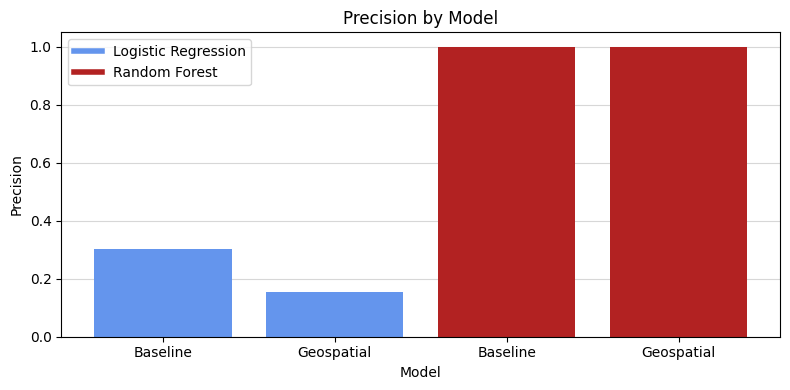

In [283]:
plot_metrics(metrics_df, 'Precision')

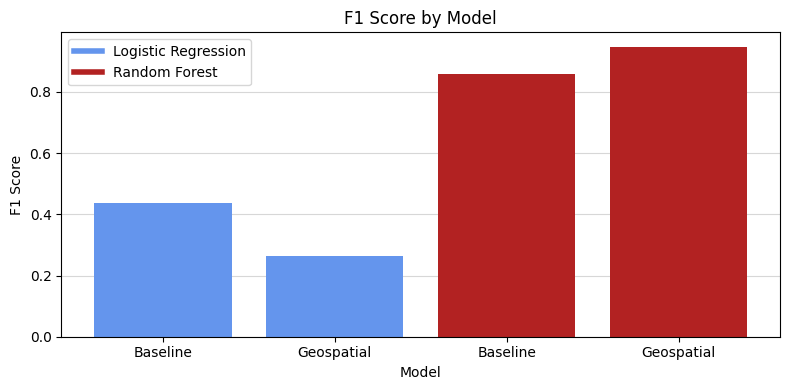

In [284]:
plot_metrics(metrics_df, 'F1 Score')

## Diagnosing Results & Conclusions

### Primary Metrics:
**Recall**:

The Geospatially Augmented Logistic Regression model has perfect recall (1.0), meaning it identifies all actual positive cases, which is essential for tsunami risk detection. This ensures that no potential tsunami risks are overlooked, which is vital in preventing loss of life and property. The Geospatially Augmented Random Forest has a recall of 0.90, indicating it misses a few positive cases, which could be critical in this application. In high-stakes scenarios like tsunami detection, every missed positive case could have serious implications. All models performed reasonably here, but the Geospatial Augmented models outperformed the baseline models.

**ROC-AUC**:

The Random Forest models show extremely high ROC-AUC values, indicating they perform very well in distinguishing between earthquakes that cause tsunami risk versus no tsunami risk. The Geospatially Augmented Random Forest Classifier performs best with a perfect ROC-AUC score of 1.0, indicating that it perfectly distinguished between positive and negative thresholds. Also, the Baseline Random Forest model has strong discrimination ability with a AUC of 0.997. The Logistic Regression models also have strong ROC-AUCs (~0.93) but they are lower than their counterparts.

### Secondary Metrics:
**Precision**:

Precision is less critical in this context; it is better to have a false positive than false negative. But, it is still useful to monitor precision to understand how many of the positive predictions made by the model are actually true positives. Both Random Forest models achieve perfect precision (1.0), indicating that all positive predictions made by the model are true positives. On the other hand, the Logistic Regression models have low precision, and the Geospatially Augmented Logistic Regression model has the lowest precision of 0.15, meaning there were a lot of false positives. Perhaps this model had a propensity to predict positive cases excessively. In such a system were implemented, this tendency could lead to downsides including mass confusion or resource misallocation during critical situations.

**F1 Score**:

The F1 score balances precision and recall. The Random Forest models have the highest F1 Scores, due to the perfect precisions and significantly high recalls. The Logistic Regression Models have lower F1 scores as a result of poor precision.

### Conclusions:

In evaluating the models based on the primary metrics, both Geospatially Augmented models demonstrate superior performance in detecting tsunami risks. The Geospatially Augmented Logistic Regression model achieves a perfect recall and identifies all actual positive cases, which is crucial for minimizing the risks of false negatives. Also, the Geospatially Augmented Random Forest Classifier performs exceptionally well with a substantially high recall of 0.9 and perfect precision. All together, these results suggest that the geospatial features extracted from the data were valuable in helping the models understand correlations between proximity to coastline and tsunami risks.

While the Random Forest models provide the robust ability to distinguish between classes, they may overlook some tsunami threats due to their lower recall scores. On the other hand, the Logistic Regression models have better recall scores on average, but are more prone to false positives, potentially leading to false alarms.

In conclusion, the two Geospatially Augmented models strike a balance between identifying true tsunami risks and the risk of generating false alarms: the Logistic Regression model achieving a recall of 1.0 and Random Forest model achieving a precision of 1.0. Choosing between these approaches entails a trade off: adopting the Random Forest model may ensure fewer false negatives but risks overlooking some of the real threats, whereas the Logistic Regression model maximizes detecting true threats at the expense of false alarms. Given these considerations, what would you prefer: the potential for false alarms, or the risk of your city being decimated by a tsunami?

#### Limitations:

It is important to acknowledge the limitations posed by the limited size of this dataset. Performance of these models may not generalize well to unseen data and this emphasizes the need for further expansion and validation on larger datasets. The data used to train these models are constrained to a year and a half timeline from 2023 to 2024.